# Learning Curves

In [4]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [5]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
#original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [6]:
#start_time = '2012-02-01 00:00:00'
start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
#splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

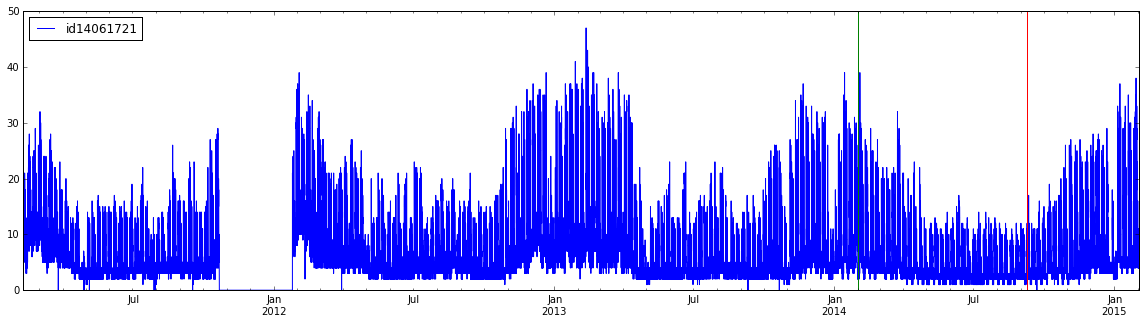

In [7]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [76]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
from neural_network import PyBrainNN

## Creating Feature Sets

Warning: This feature sets should change when you compute new feature importances!!

In [9]:
autoregressive_ftrs = ['measurement', 'measurement_1d', 'measurement_2d', 'measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_energija_gl', 'shifted_BusinessDay', 'measurement',
              'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
              'measurement_roll_mean_w', 'shifted_DayOfWeek', 'energija_gl_roll_mean_6h', 'measurement_roll_var_6h', 
              't2m_termin_roll_mean_m', 'energija_gl_roll_mean_1h', 'shifted_t2m_termin', 'p_roll_var_d', 
              'measurement_roll_mean_m', 'energija_gl_roll_mean_m', 'energija_gl']

top10_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_energija_gl', 'shifted_BusinessDay', 'measurement',
              'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
              'measurement_roll_mean_w']

selected_ftrs = ['shifted_HourOfDay', 'measurement_roll_mean_6h', 'shifted_BusinessDay', 'measurement',
                 'measurement_roll_mean_d', 'measurement_roll_mean_1h', 'measurement_roll_var_w', 'measurement_roll_max2_w',
                 'measurement_roll_mean_w', 'shifted_DayOfWeek', 'measurement_roll_var_6h', 'measurement_roll_mean_m']

In [10]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs
seleceted_ftrs = selected_ftrs

## Adding Neural Network Module

## Define Models, Feature sets and Error metrics

In [82]:
models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          {'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          {'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 10, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"}
          ]

data_sets = [#{'name': "AR", 'ftrs': ar_ftrs},
             {'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             {'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             {'name': "SELECTED", 'ftrs': seleceted_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 {'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error}
                ]

#Learning Curves

In [78]:
# Create dataframe for specific sensor
sensor_name = 'id14061721'
sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
sensor_data = data[sensor_data_ftrs]

# Replace 'sensor id' column names with 'measurement'
sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

# Prepare columns to shift
columnsToShift = list(sensor_data)
shiftedColumns = ["shifted_" + col for col in columnsToShift]

# Shift columns
horizon = 10
sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
sensor_data.dropna(inplace=True)

# Split Training and Testing set
training_data = sensor_data[:splitting_time]
testing_data = sensor_data[splitting_time:]

# Create dummy feature vector for linear regression
sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
        prefix='dummy_shifted_Month'))))
#sensor_data_dummy.dropna(inplace=True)
dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
training_data_dummy = sensor_data_dummy[:splitting_time]
testing_data_dummy = sensor_data_dummy[splitting_time:]

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# Ref: http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
def plot_learning_curve(ax, estimator, X, y, title=None, xlabel=None, ylabel=None, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    #ax.legend(loc=4)
    
    return ax


Working on Ridge Regression model...
-->Feature set: AR_WC_WF
-->Feature set: AR_DT
-->Feature set: ALL
-->Feature set: TOP_20
-->Feature set: SELECTED

Working on K Nearest Neighbors model...
-->Feature set: AR_WC_WF
-->Feature set: AR_DT
-->Feature set: ALL
-->Feature set: TOP_20
-->Feature set: SELECTED

Working on Random Forest model...
-->Feature set: AR_WC_WF
-->Feature set: AR_DT
-->Feature set: ALL
-->Feature set: TOP_20
-->Feature set: SELECTED

Working on SVR model...
-->Feature set: AR_WC_WF
-->Feature set: AR_DT
-->Feature set: ALL
-->Feature set: TOP_20
-->Feature set: SELECTED

Working on Neural Network model...
-->Feature set: AR_WC_WF
-->Feature set: AR_DT
-->Feature set: ALL
-->Feature set: TOP_20
-->Feature set: SELECTED


<function matplotlib.pyplot.show>

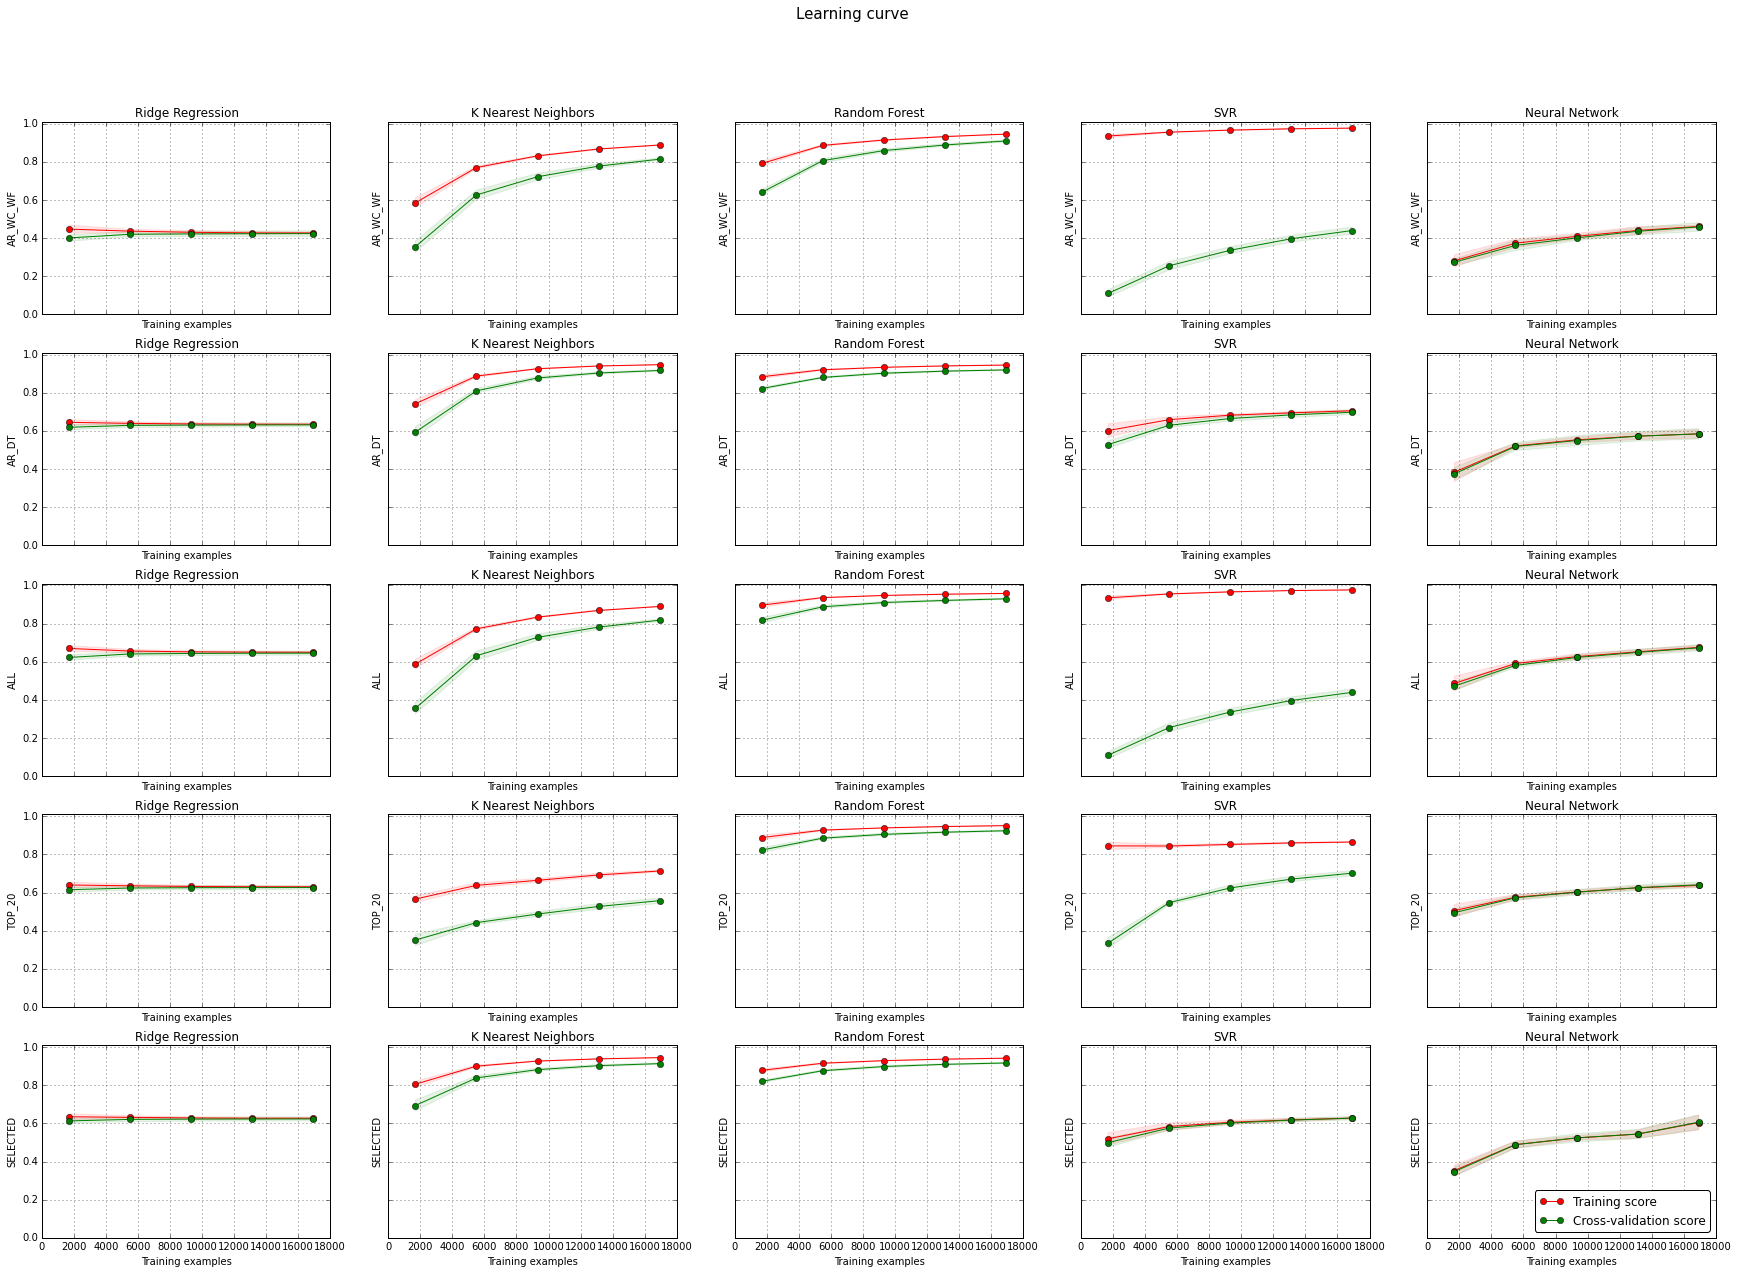

In [83]:
f, axx = plt.subplots(len(data_sets), len(models), sharey=True, sharex=True)
f.set_size_inches(6*len(models),4*len(data_sets)) # f.set_size_inches(20,13)
plt.suptitle('Learning curve', fontsize=15)

for idx, model in enumerate(models):
    print "\nWorking on " + model['name'] + " model..."
    estimator = eval(model['init'])
    
    for idy, data_set in enumerate(data_sets):
        print "-->Feature set:", data_set['name']
                    
        # Create dummy feature vector for linear regression
        if "shifted_HourOfDay" in data_set['ftrs']: 
            X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
            X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
        else: 
            X_train_dummy = training_data_dummy[data_set['ftrs']].values
            X_test_dummy = testing_data_dummy[data_set['ftrs']].values 
        
        y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
        y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                
        # Create training vectors
        if model['name'] == "Ridge Regression":
            X = X_train_dummy
            y = y_train_dummy
        else: 
            X = training_data[data_set['ftrs']].values
            y = training_data[["shifted_measurement"]].values.ravel()
        
        
        cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)
        plot_learning_curve(axx[idy,idx], estimator, X, y, model['name'], "Training examples", 
                            data_set['name'], (0.0, 1.01), cv=cv, n_jobs=1)

plt.legend(loc=4, fancybox=True)
plt.show

#Feature Importances

-->Feature set: AR_WC_WF
-->Feature set: AR_DT
-->Feature set: ALL
-->Feature set: TOP_20
-->Feature set: SELECTED


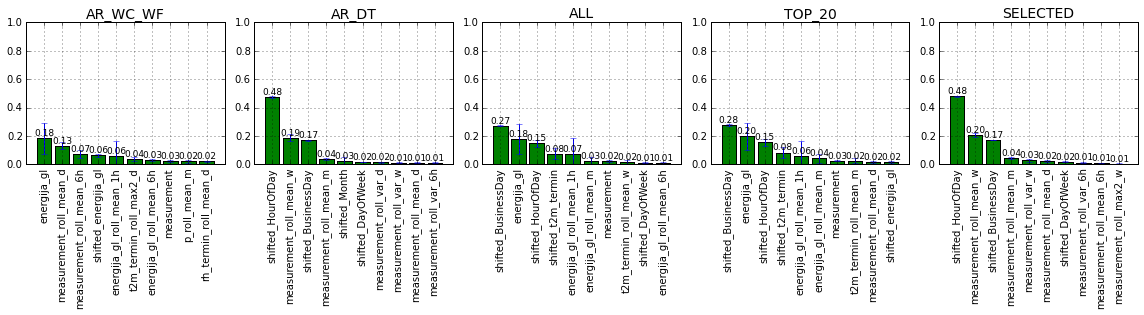

In [95]:
num_of_top_important_ftrs = 10;

fig, axes = plt.subplots(1, len(data_sets))
fig.set_size_inches(16,4.5)
#fig.set_size_inches(20,3)
#plt.suptitle('Feature Imprtance', fontsize=15)
#plt.subplots_adjust(top=3)
plt.setp(axes, xticks=xrange(num_of_top_important_ftrs), xlim = [-1, num_of_top_important_ftrs], ylim=[0, 1])

model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=7)

for idx, data_set in enumerate(data_sets):
   
    print "-->Feature set:", data_set['name']
    X = training_data[data_set['ftrs']].values
    y = training_data[["shifted_measurement"]].values.ravel()
    model.fit(X, y)
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:num_of_top_important_ftrs]
    ftr_size = num_of_top_important_ftrs if X.shape[1] > num_of_top_important_ftrs else X.shape[1] 
    
    for f in range(ftr_size):
        axes[idx].annotate( str("%.2f" % importances[indices[f]]), (f, importances[indices[f]] + 0.02), fontsize=9, ha='center')
    
    # Plot the feature importances of the forest
    axes[idx].set_title(data_set['name'], fontsize=14)
    axes[idx].bar(xrange(ftr_size), importances[indices], color="g", yerr=std[indices], align="center")
    axes[idx].set_xticklabels(training_data[data_set['ftrs']].columns[indices], rotation='vertical')
    axes[idx].grid(True)

fig.tight_layout()
plt.show()